In [4]:
import math
import numpy as np
import random
#from scipy.spatial import Delaunay
import drawsvg as draw
#import os

In [5]:
def cross(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return False
    intersectX, intersectY = x/z, y/z
    if (b1==a1) or (b2==a1) or (b1==a2) or (b2==a2):
        return False
    lowerx = max(min(a1[0],a2[0]),min(b1[0],b2[0]))
    higherx = min(max(a1[0],a2[0]),max(b1[0],b2[0]))
    lowery = max(min(a1[1],a2[1]),min(b1[1],b2[1]))
    highery = min(max(a1[1],a2[1]),max(b1[1],b2[1]))
    doesCross = (lowerx<=intersectX)and(intersectX<=higherx)and(lowery<=intersectY)and(intersectY<=highery)
    #if doesCross:
        #print(f'a1:{a1} ,a2:{a2} ,b1:{b1} ,b2:{b2} crossing in {intersectX},{intersectY}')
    return doesCross

In [7]:
randomSegments = []
#numberOfGraphs = 100
numberOfGraphs = 86
n = 100

windowwidth = 1000
windowheight = windowwidth #square
border = 250

setOfPoints=[]
setOfEdges=[]
setOfNeighbours=[]
setOfDiscardedEdges=[]

for i in range(numberOfGraphs):
    points = []
    points.append([border,windowheight-border])
    points.append([border,border])
    points.append([windowwidth-border,border])
    for j in range(3,n):
        x = border+(windowwidth-2*border)*random.random()
        y = border+(windowheight-2*border)*random.random()
        if y >= windowwidth-x:
            yDist= y-(windowwidth-x)
            x-=yDist
            y-=yDist
        points.append([x,y])
    
    allPossibleEdges = []
    for v in range(n):
        for w in range(v+1,n):
            allPossibleEdges.append([v,w])
            
    neighbours =[]
    for v in range(n):
        neighbours.append([])
    
    random.shuffle(allPossibleEdges)
    
    edges = []
    discardedEdges = []
    
    #print(f'n: {len(points)}, all edges: {len(allPossibleEdges)}')
    numberOfEdges = 0
    i = 0
    while numberOfEdges<(3*n-6):
        checkEdge = allPossibleEdges[i]
        edgeFrom = checkEdge[0]
        edgeTo = checkEdge[1]
        edgeFromCoordinates = points[edgeFrom]
        edgeToCoordinates = points[edgeTo]
        #print(f"we're at: {numberOfEdges} edges")
        if all( (not cross(points[edge[0]],points[edge[1]],edgeFromCoordinates, edgeToCoordinates)) for edge in edges):
            #crossing free, we can add the edge
            edges.append(checkEdge)
            numberOfEdges+=1
            neighbours[checkEdge[0]].append(checkEdge[1])
            neighbours[checkEdge[1]].append(checkEdge[0])
        else:
            discardedEdges.append(checkEdge)
        i+=1

    setOfPoints.append(points)
    setOfEdges.append(edges)
    setOfNeighbours.append(neighbours)
    setOfDiscardedEdges.append(discardedEdges)

In [8]:
###PRINT AS SEGMENTS#####
setOfSegments = []
for i in range(numberOfGraphs):
    points = setOfPoints[i]
    segments = []
    for e in setOfEdges[i]:
        segment =[points[e[0]],points[e[1]]]
        segments.append(segment)
    setOfSegments.append(segments)

In [9]:
#INLINE OUTPUT
#print(f'randomSegments = {setOfSegments}')

In [11]:
##GENERATE PATHS IN THE PRIMAL##############
alongEdgesPaths = []
for i in range(numberOfGraphs):
    #pick s and t
    s = random.randint(0,n-1)
    t = random.randint(0,n-1)
    while t==s:
        t = random.randint(0,n-1)
    neighbours = setOfNeighbours[i]
    
    #do some bfs on the graph
    predecessor = [-1]*n
    seen = [False]*n
    queue = [t]
    seen[t] = True
    while True:
        vertex = queue.pop(0)
        if vertex==s:
            break
        for neighbour in neighbours[vertex]:
            if not seen[neighbour]:
                seen[neighbour] = True
                predecessor[neighbour] = vertex
                queue.append(neighbour)
    
    points = setOfPoints[i]
    path =[]
    
    while vertex != t:
        point = points[vertex]
        path.append(point)
        vertex = predecessor[vertex]
    ## add t
    point = points[t]
    path.append(point)
    alongEdgesPaths.append(path)

In [12]:
#INLINE OUTPUT
#print(f'alongEdgesPaths = {alongEdgesPaths}')

In [13]:
##GENERATE PATHS IN THE DUAL##############

In [14]:
def getAngle(thispoints, indexV, indexW):
    return math.atan2(thispoints[indexV][1] - thispoints[indexW][1], thispoints[indexV][0] - thispoints[indexW][0])
    
    
setOfTriangles = []
setOfDualneighbours = []
for k in range(numberOfGraphs):
    neighbours = setOfNeighbours[k]
    points = setOfPoints[k]
    #sort the neighbours clockwise (or counterclockwise)
    for i in range(n):
        neighboursOfI = neighbours[i]
        neighboursOfI.sort(key=lambda x:getAngle(points,i,x))
    
    #build the set of triangles
    triangles = set()
    dualneighbours = dict()
    for i in range(n): #for every vertex
        v = neighbours[i][len(neighbours[i])-1]
        w = neighbours[v][(neighbours[v].index(i)+1)%len(neighbours[v])]
        tmp_triangle = [i,v,w]
        tmp_triangle.sort()
        tmp_triangle = tuple(tmp_triangle)
        if not tmp_triangle in dualneighbours:
            dualneighbours[tmp_triangle]=set()

        for v in neighbours[i]:
            w = neighbours[v][(neighbours[v].index(i)+1)%len(neighbours[v])]
            triangle = [i,v,w]
            triangle.sort()
            triangle = tuple(triangle)
            triangles.add(triangle)
            if not triangle in dualneighbours:
                dualneighbours[triangle]=set()
            dualneighbours[triangle].add(tmp_triangle)
            dualneighbours[tmp_triangle].add(triangle)
            tmp_triangle = triangle
    setOfTriangles.append(triangles)
    setOfDualneighbours.append(dualneighbours)
                
    #build the set of dual edges by describing neighborhoods.

In [15]:
### now get some paths, similar to the alongEdges Case
alongFacesPaths = []
for i in range(numberOfGraphs):
    triangles = setOfTriangles[i]
    dualneighbours = setOfDualneighbours[i]
    f = len(triangles)
    
    picks = random.sample(triangles, k=2)
    s = picks[0]
    t = picks[1]
    while s==(0,1,2) or t==(0,1,2):
        picks = random.sample(triangles, k=2)
        s = picks[0]
        t = picks[1]
    
    #do some bfs on the graph   
    predecessor = dict()
    seen = dict()
    for triangle in triangles:
        seen[triangle]=False
    queue = [t]
    seen[t] = True
    seen[(0,1,2)]
    while True:
        triangle = queue.pop(0)
        if triangle==s:
            break
        for dualneighbour in dualneighbours[triangle]:
            if not seen[dualneighbour]:
                seen[dualneighbour] = True
                predecessor[dualneighbour] = triangle
                queue.append(dualneighbour)
    
    points = setOfPoints[i]
    path =[]
    
    while triangle != t:
        xCoordinate = (points[triangle[0]][0]+points[triangle[1]][0]+points[triangle[2]][0])/3
        yCoordinate = (points[triangle[0]][1]+points[triangle[1]][1]+points[triangle[2]][1])/3
        point = [xCoordinate,yCoordinate]
        path.append(point)
        triangle = predecessor[triangle]
    ##add t:
    xCoordinate = (points[triangle[0]][0]+points[triangle[1]][0]+points[triangle[2]][0])/3
    yCoordinate = (points[triangle[0]][1]+points[triangle[1]][1]+points[triangle[2]][1])/3
    point = [xCoordinate,yCoordinate]
    path.append(point)
    alongFacesPaths.append(path)
    


In [16]:
#INLINE OUTPUT
#print(f'alongFacesPaths = {alongFacesPaths}')

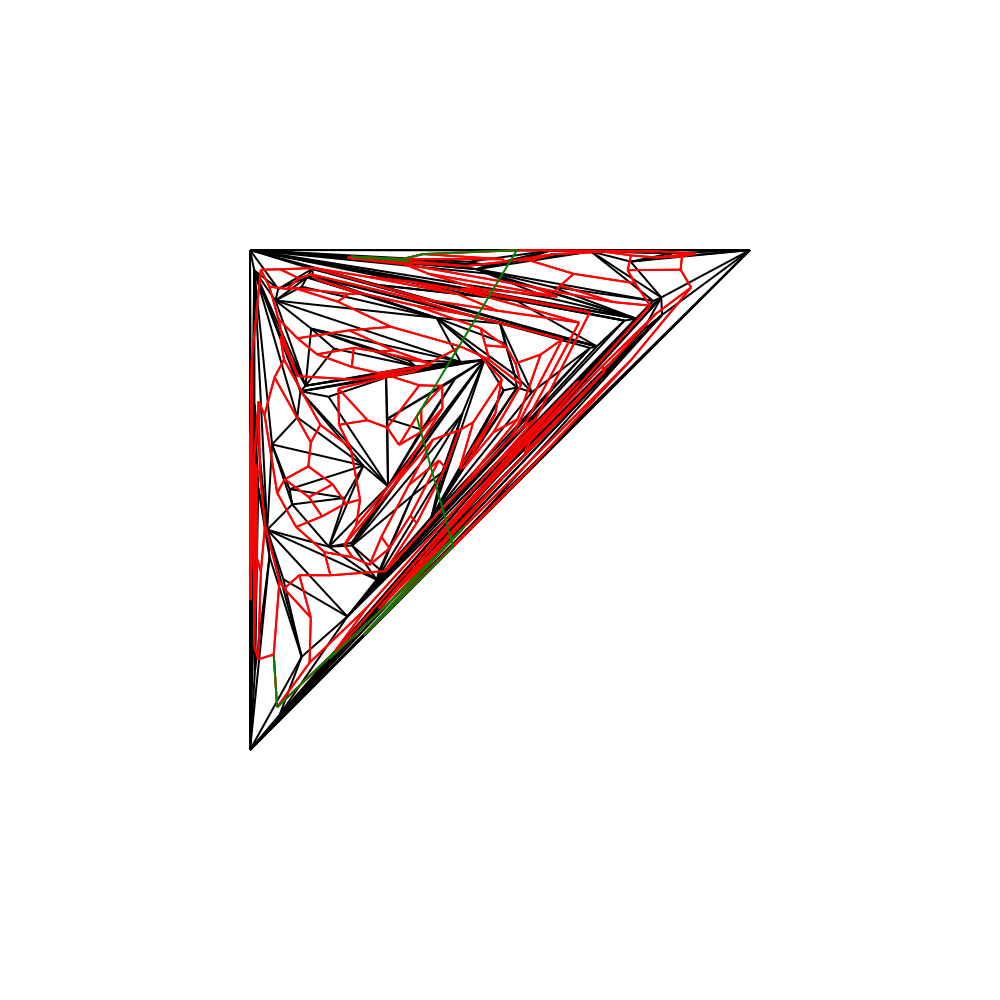

In [17]:
## VISUAL OUTPUT
scaling = 1
d = draw.Drawing(windowwidth*scaling, windowheight*scaling, origin=(0,0))
#draw discarded edges
for e in discardedEdges:
    startx=points[e[0]][0]*scaling
    starty=points[e[0]][1]*scaling
    endx=points[e[1]][0]*scaling
    endy=points[e[1]][1]*scaling
    
    #d.append(draw.Line(startx,starty,endx,endy, stroke='red', stroke_width=2))

#draw edges
for e in edges:
    startx=points[e[0]][0]*scaling
    starty=points[e[0]][1]*scaling
    endx=points[e[1]][0]*scaling
    endy=points[e[1]][1]*scaling
    
    d.append(draw.Line(startx,starty,endx,endy, stroke='black', stroke_width=2))
    
#draw dual edges
for triangle in dualneighbours:
    if triangle ==(0,1,2): continue
    for dn in dualneighbours[triangle]:
        if dn ==(0,1,2): continue
        startx = (points[triangle[0]][0]+points[triangle[1]][0]+points[triangle[2]][0])/3
        starty = (points[triangle[0]][1]+points[triangle[1]][1]+points[triangle[2]][1])/3
        endx = (points[dn[0]][0]+points[dn[1]][0]+points[dn[2]][0])/3
        endy = (points[dn[0]][1]+points[dn[1]][1]+points[dn[2]][1])/3
    
        d.append(draw.Line(startx,starty,endx,endy, stroke='red', stroke_width=2))
    
#draw path
i = 0
while i<(len(path)-1):
    startx=path[i][0]*scaling
    starty=path[i][1]*scaling
    endx=path[i+1][0]*scaling
    endy=path[i+1][1]*scaling
    d.append(draw.Line(startx,starty,endx,endy, stroke='green', stroke_width=2))
    i+=1

d

In [18]:
#INLINE OUTPUT
print(f'randomSegments = {setOfSegments}')
print(f'#################################')
print(f'alongEdgesPaths = {alongEdgesPaths}')
print(f'#################################')
print(f'alongFacesPaths = {alongFacesPaths}')

randomSegments = [[[[619.0958372451156, 333.023588358281], [348.12824662501015, 437.4826101762318]], [[413.07217370160566, 547.5774614892446], [290.29593910346546, 618.713977510158]], [[324.1691636119557, 670.351006288975], [276.18950597711705, 637.663138626665]], [[540.5952607962696, 365.6370618011671], [331.13686768489856, 585.9423887794725]], [[358.44824563845543, 292.0187288552613], [263.84481595697963, 332.470901845611]], [[324.7725940345206, 381.36255197658306], [277.17098655618975, 341.6909549507792]], [[334.7634588349538, 550.1463601580473], [256.99237987036213, 527.6099266275708]], [[432.4493614042515, 416.5014329072377], [276.18950597711705, 637.663138626665]], [[432.4493614042515, 416.5014329072377], [501.3551851633441, 396.5532342105895]], [[265.83411274299954, 505.2228234863959], [321.8895496098583, 464.3216133105314]], [[250, 750], [256.76231927508536, 437.5790543930077]], [[334.7634588349538, 550.1463601580473], [341.7144953907, 310.47786621979503]], [[750, 250], [577.07

In [19]:
%store setOfSegments
%store alongEdgesPaths
%store alongFacesPaths

Stored 'setOfSegments' (list)
Stored 'alongEdgesPaths' (list)
Stored 'alongFacesPaths' (list)
